<a href="https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_img2img_example.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion - Img2Img 🎨 

This notebook shows an example of how to run `diffusers_interpret.StableDiffusionImg2ImgPipelineExplainer` to explain `diffusers.StableDiffusionImg2ImgPipeline`.

In [1]:
!pip install -U diffusers-interpret

### 0 - Login in HuggingFace's Hub

In [2]:
from huggingface_hub import notebook_login
notebook_login()

### 1 - Initialize `StableDiffusionImg2ImgPipeline` normally

In [3]:
# make sure you're logged in by running the previous cell or `huggingface-cli login`
import torch
from contextlib import nullcontext
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline


device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    
    # FP16 is not working for 'cpu'
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)
pipe.enable_attention_slicing() # comment this line if you wish to deactivate this option

{'trained_betas'} was not found in config. Values will be initialized to default values.


### 2 - Pass `StableDiffusionImg2ImgPipeline` to `StableDiffusionImg2ImgPipelineExplainer`

In [4]:
from diffusers_interpret import StableDiffusionImg2ImgPipelineExplainer

explainer = StableDiffusionImg2ImgPipelineExplainer(pipe, gradient_checkpointing=True)

### 3 - Generate an image with the `StableDiffusionImg2ImgPipelineExplainer` object

Note that the `explainer()` method accepts all the arguments that `pipe()` accepts. 

We also pass a `generator` argument so that we get a deterministic output.

In [5]:
prompt = "A fantasy landscape, trending on artstation"

# let's download an initial image
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((448, 448))

generator = torch.Generator(device).manual_seed(42)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5, generator=generator
    )

  0%|          | 0/38 [00:00<?, ?it/s]

Calculating token and image pixel attributions... Done!


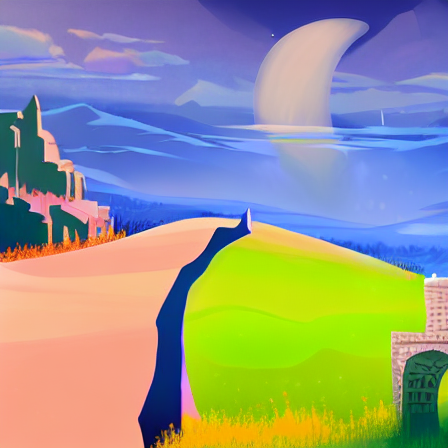

In [6]:
# Final image
output.image

#### 3.1 - Input Saliency Maps

It is now possible to visualize the computed pixel attributions in a saliency map

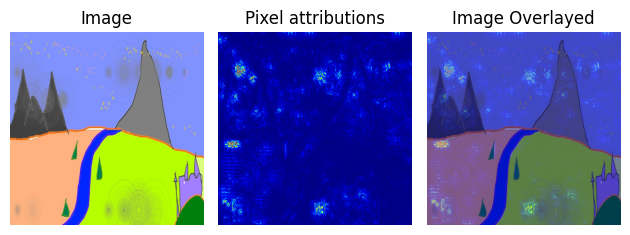

In [7]:
output.input_saliency_map.show(cmap='jet', image_weight=0.5)

Or access the pixel attributions directly

In [8]:
output.pixel_attributions.shape

(448, 448)

In [9]:
output.pixel_attributions

array([[ 1.2714844 ,  4.15625   ,  7.8203125 , ...,  2.7753906 ,
         2.1308594 ,  0.66552734],
       [ 5.5078125 , 11.1953125 ,  4.8125    , ...,  5.6367188 ,
         6.8828125 ,  3.0136719 ],
       [ 5.9765625 ,  2.8457031 ,  4.9296875 , ...,  3.9082031 ,
         6.7773438 ,  3.2636719 ],
       ...,
       [ 0.49121094,  2.8457031 ,  3.859375  , ...,  3.4550781 ,
         2.1816406 ,  0.8178711 ],
       [ 0.21386719,  1.8867188 ,  2.2109375 , ...,  3.0859375 ,
         2.7421875 ,  0.7871094 ],
       [ 0.85791016,  0.6694336 ,  1.71875   , ...,  3.8496094 ,
         1.4589844 ,  0.5727539 ]], dtype=float32)

Or their normalized version

In [10]:
output.normalized_pixel_attributions

array([[7.16054201e-05, 2.34065039e-04, 4.40411852e-04, ...,
        1.56300011e-04, 1.20002325e-04, 3.74801020e-05],
       [3.10180156e-04, 6.30479713e-04, 2.71022669e-04, ...,
        3.17439699e-04, 3.87615233e-04, 1.69719147e-04],
       [3.36578465e-04, 1.60259748e-04, 2.77622225e-04, ...,
        2.20095928e-04, 3.81675578e-04, 1.83798256e-04],
       ...,
       [2.76632309e-05, 1.60259748e-04, 2.17346082e-04, ...,
        1.94577544e-04, 1.22862140e-04, 4.60595547e-05],
       [1.20442292e-05, 1.06253210e-04, 1.24512037e-04, ...,
        1.73788882e-04, 1.54430119e-04, 4.43271674e-05],
       [4.83144104e-05, 3.77000870e-05, 9.67938031e-05, ...,
        2.16796136e-04, 8.21647482e-05, 3.22554370e-05]], dtype=float32)

#### 3.2 - You still have access to all the features that exist in `StableDiffusionPipelineExplainer`

Here are some examples below. Find out more features in [this notebook](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_example_colab.ipynb).

In [11]:
# (token, attribution_percentage)
output.normalized_token_attributions

[('a', 6.946),
 ('fantasy', 24.787),
 ('landscape', 19.845),
 (',', 7.298),
 ('trending', 2.826),
 ('on', 5.53),
 ('art', 10.417),
 ('station', 22.352)]

In [12]:
# Google Colab does not render the IFrame from the code below, only works locally on your Jupyter Notebook.
output.all_images_during_generation.show(width="100%", height="400px")

###########################################################################################################################
# As an alternative to visualize the produced HTML, run:
import os, shutil, diffusers_interpret
shutil.copy2(os.path.join(os.path.dirname(diffusers_interpret.__file__), "dataviz", "image-slider", "final.html"), '.')

# and open the saved './final.html' manually

'./final.html'